#Implementasi Deep Learning Menggunakan Arsitektur CNN Inception-ResNet Pada Face Mask Detection

Tujuan dari implementasi Deep Learning menggunakan arsitektur Inception-ResNet pada Face Mask Detection adalah untuk membangun sebuah sistem yang dapat secara otomatis mendeteksi apakah seseorang memakai masker atau tidak berdasarkan gambar atau video wajah. Sistem ini biasanya dibangun dengan menggunakan teknik Deep Learning, di mana model Deep Learning dilatih menggunakan sejumlah besar data gambar wajah manusia yang memakai dan tidak memakai masker.

Dalam implementasi ini, arsitektur Inception-ResNet dipilih karena arsitektur ini telah terbukti efektif dalam mengenali objek pada gambar dengan akurasi yang tinggi. Dengan menggunakan arsitektur ini, model Deep Learning dapat mempelajari fitur-fitur yang kompleks pada wajah manusia, seperti bentuk dan tekstur, sehingga dapat mengidentifikasi apakah seseorang memakai masker atau tidak.

## Import Library

In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.applications import InceptionResNetV2
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping
import numpy as np
import glob
import pandas as pd
import cv2 as cv

##Data Collection (Kaggle API)

Berikut adalah urutan untuk mengambil API pada Kaggle:

1.   **Login/Register** ke akun Kaggle dan pergi ke halaman "**Account**" di bagian atas halaman.

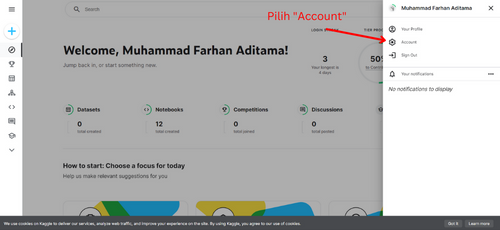

2.   Cari bagian "**API**" dan klik tombol "**Create New API Token**"

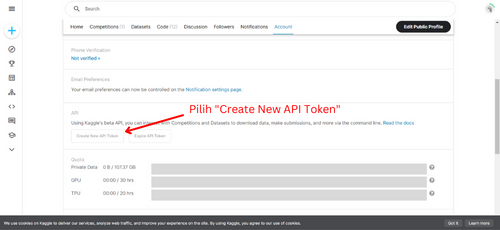

3.   Simpan file **token API** pada direktori komputer kemudian upload kedalam Google Colab melalui code dibawah ini.


In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [3]:
!kaggle datasets list -s 'Face Mask'

ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
andrewmvd/face-mask-detection                                    Face Mask Detection                                 398MB  2020-05-22 07:18:42          59150       1561  0.875            
vijaykumar1799/face-mask-detection                               Face Mask Detection                                 222MB  2021-05-19 15:24:14           4223         67  0.875            
prasoonkottarathil/face-mask-lite-dataset                        Face Mask Lite Dataset                               23GB  2020-07-12 05:14:16           7750        137  0.875            
ashishjangra27/face-mask-12k-images-dataset            

In [4]:
!kaggle datasets download omkargurav/face-mask-dataset  

 85% 139M/163M [00:00<00:00, 219MB/s]
100% 163M/163M [00:00<00:00, 203MB/s]


In [5]:
!unzip -q '/content/face-mask-dataset.zip' -d '/content/'

## Data Pre-Processing

### Data Distribution

In [19]:
path_masker = "/content/data/with_mask"
path_tanpa_masker = "/content/data/without_mask"

In [20]:
mask_names = glob.glob('../content/data/with_mask/*')
mask_names = pd.Series(mask_names)

without_mask_names = glob.glob('../content/data/without_mask/*')
without_mask_names = pd.Series(without_mask_names)

In [21]:
print("Total gambar wajah bermasker: ", len(mask_names))
print("Total gambar wajah tidak bermasker: ", len(without_mask_names))

Total gambar wajah bermasker:  3725
Total gambar wajah tidak bermasker:  3828


<BarContainer object of 2 artists>

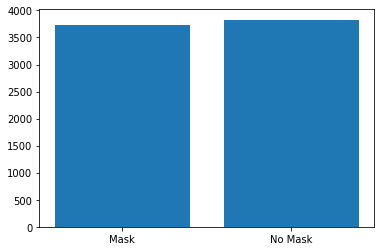

In [22]:
plt.bar(("Mask", "No Mask"), (len(mask_names), len(without_mask_names)))

Terdapat 3725 gambar wajah yang menggunakan masker dan 3828 gambar wajah tanpa masker dalam dataset.

### Data Visualization 

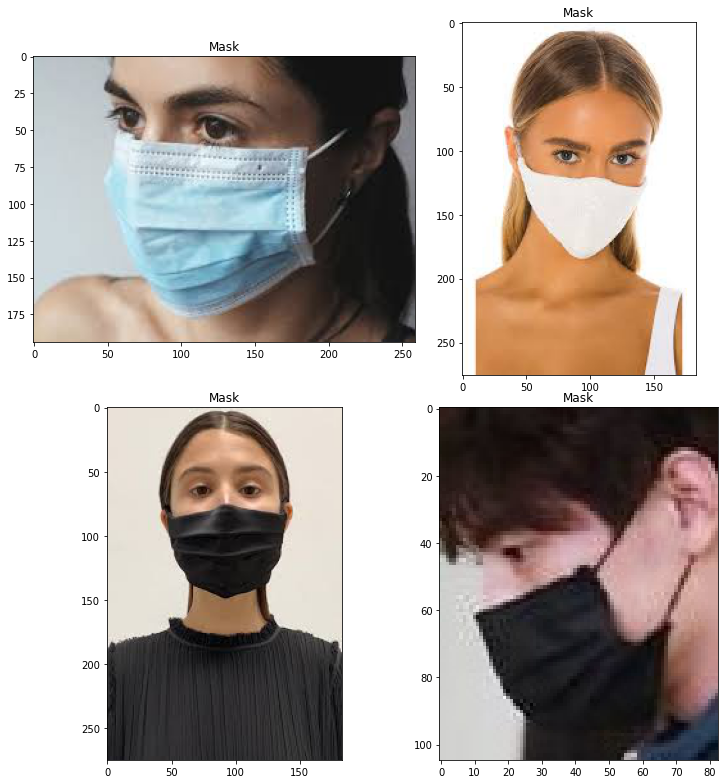

In [23]:
plt.figure(figsize=(11,11))
for i in range(1,5):
  plt.subplot(2,2,i)
  plt.tight_layout()
  plt.imshow(mpimg.imread(mask_names[i]))
  plt.title("Mask")

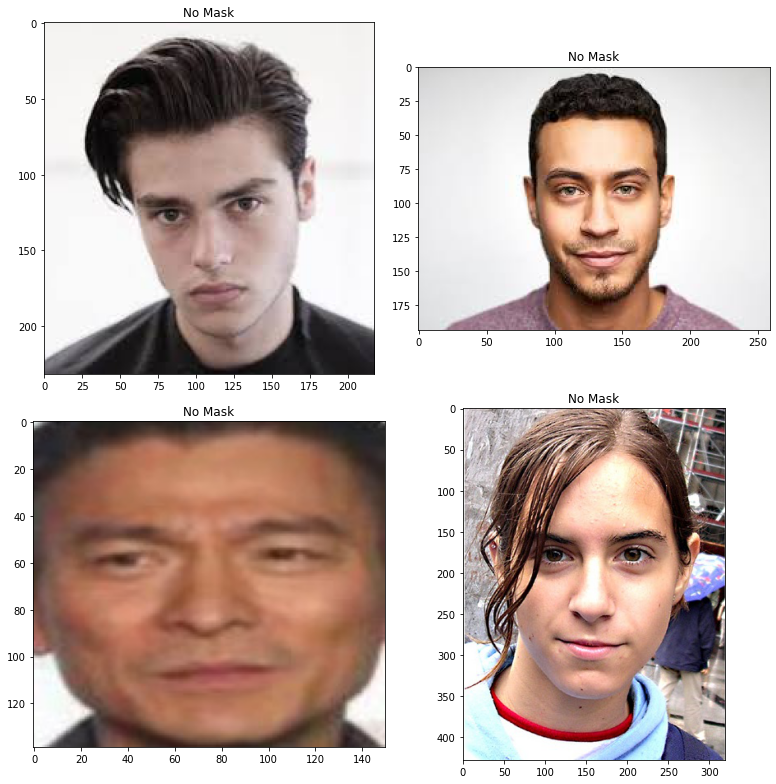

In [24]:
plt.figure(figsize=(11,11))
for i in range(1,5):
  plt.subplot(2,2,i)
  plt.tight_layout()
  plt.imshow(mpimg.imread(without_mask_names[i]))
  plt.title("No Mask")

###Data Splitting

Dataset splitting adalah teknik yang umum digunakan dalam machine learning untuk membagi dataset menjadi tiga bagian yang berbeda: training set, validation set, dan test set. Tujuan dari dataset splitting adalah untuk menguji performa model pada data yang tidak pernah dilihat sebelumnya.

Berikut adalah penjelasan singkat tentang ketiga jenis dataset dalam dataset splitting:

1.  Training set: dataset ini digunakan untuk melatih model. Model menggunakan data dalam training set untuk belajar pola dan tren dalam data dan mengoptimalkan parameter model.

2.  Validation set: dataset ini digunakan untuk mengukur performa model selama proses pelatihan. Selama pelatihan, model dievaluasi menggunakan data validasi untuk mengoptimalkan parameter dan menghindari overfitting atau underfitting.

3.  Test set: dataset ini digunakan untuk mengukur performa akhir model setelah pelatihan selesai. Setelah model dilatih dan dioptimalkan pada training dan validation set, model diuji pada data test untuk menilai performa model secara objektif.

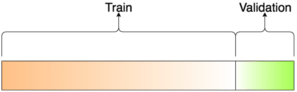

Namun, dalam studi kasus ini proporsi yang digunakan dalam dataset splitting adalah 80-20, yang berarti 80% dari data digunakan untuk training dan 20% digunakan untuk validasi. Sedangkan untuk data testing tidak digunakan.

In [25]:
path_data_baru = './DatasetNew'
os.mkdir(path_data_baru)

In [26]:
train_dir = os.path.join(path_data_baru, 'train')
test_dir = os.path.join(path_data_baru, 'test')


masker_train = os.path.join(train_dir,'with_mask')
masker_test = os.path.join(test_dir,'with_mask')

tanpamasker_train = os.path.join(train_dir,'without_mask')
tanpamasker_test = os.path.join(test_dir,'without_mask')

list_dir = [train_dir,test_dir,masker_train,masker_test,tanpamasker_train,tanpamasker_test]

for i in list_dir:
  os.mkdir(i)

In [27]:
train_masker_dir, test_masker_dir = train_test_split(os.listdir(path_masker), test_size = 0.20, random_state=0)
train_tanpamasker_dir, test_tanpamasker_dir = train_test_split(os.listdir(path_tanpa_masker), test_size = 0.20, random_state=0)

In [28]:

for i in train_masker_dir:
  shutil.copy(os.path.join(path_masker,i), os.path.join(masker_train,i))
for i in test_masker_dir:
  shutil.copy(os.path.join(path_masker,i), os.path.join(masker_test,i))

for i in train_tanpamasker_dir:
  shutil.copy(os.path.join(path_tanpa_masker,i), os.path.join(tanpamasker_train,i))
for i in test_tanpamasker_dir:
  shutil.copy(os.path.join(path_tanpa_masker,i), os.path.join(tanpamasker_test,i))

###Image Augmentation

Image augmentation adalah teknik dalam deep learning untuk membuat varian baru dari data gambar dengan mengubah dan memanipulasi citra yang sudah ada. Tujuan dari image augmentation adalah untuk memperluas dataset dan meningkatkan kemampuan model dalam mempelajari pola dan fitur pada data gambar.

Berikut adalah beberapa teknik image augmentation yang akan digunakan:

1.  **Scaling** digunakan untuk mengubah ukuran gambar dengan mempertahankan aspek rasio
2.  **Flipping** mengubah gambar dengan membalik citra secara horizontal atau vertikal.
3.   **Rotation** digunakan untuk memutar gambar dalam berbagai sudut
4.   **Shearing** digunakan untuk memberikan efek visual pada gambar seperti distorsi atau efek bayangan
5.   **Fill Mode** digunakan untuk  mengisi piksel pada gambar yang berubah ukuran (resize) atau dipotong, dalam hal ini menggunakan **"nearest"** yaitu mengisi piksel yang kosong dengan nilai piksel terdekat dari lokasi piksel yang kosong.



In [29]:
train_datagen = ImageDataGenerator(
                rescale = 1./255, 
                horizontal_flip = True,
                rotation_range= 10,
                shear_range= 10,
                fill_mode = 'nearest')

test_datagen = ImageDataGenerator(
               rescale = 1./255)

In [30]:
train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (224, 224),
                  batch_size = 64,
                  color_mode='rgb',
                  shuffle=True,
                  class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(
                 test_dir ,
                 target_size = (224, 224),
                 batch_size = 64,
                 color_mode='rgb',
                 class_mode = 'binary')

Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


In [31]:
train_generator.class_indices.keys()

dict_keys(['with_mask', 'without_mask'])

In [32]:
validation_generator.class_indices

{'with_mask': 0, 'without_mask': 1}

## Modeling & Training

Pada proses modeling akan menggunakan model InceptionResNetV2 (Doc: https://keras.io/api/applications/inceptionresnetv2/) dengan bobot(*weigths*) pre-trained dari ImageNet yang sudah di ***freeze*** serta lapisan akhir tidak digunakan dan Input gembar RGB dengan ukuran 224 x 224 piksel. 

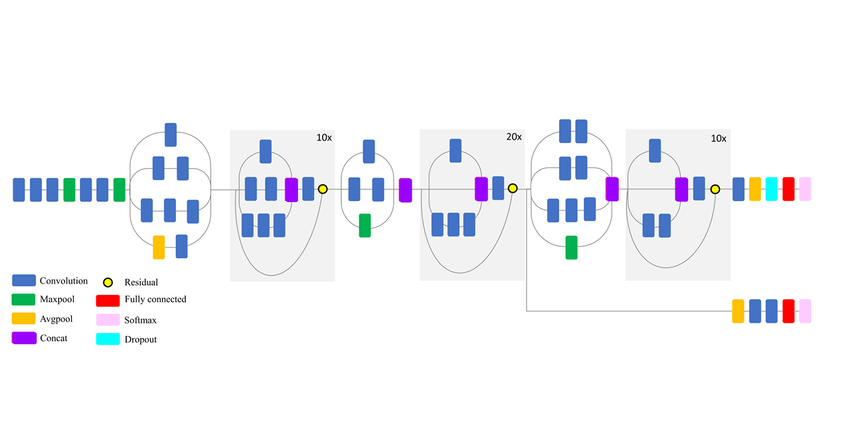

Sebelum masuk ke dalam Fully-Connected Layer, model akan dilakukan proses flatten, **"Flatten"** adalah istilah dalam deep learning yang merujuk pada proses mengubah matriks atau tensor multidimensi menjadi array satu dimensi. Pada dasarnya gambar dapat direpresentasikan sebagai matriks (matrix) numerik, yang terdiri dari piksel yang tersusun dalam baris dan kolom. 

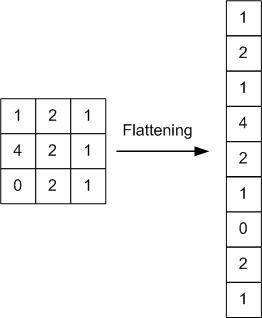

Setelah flatten akan ditambah lapisan Dense dengan activation function "Sigmoid" karena keluaran dari suatu model atau sistem ini hanya memiliki dua kemungkinan nilai atau kategori yang mungkin, yaitu 0 dan 1 masing-masing menunjukkan kelas yang dihasilkan oleh model, seperti "masker" atau "tanpa masker".

In [65]:
MODEL = []
LOSS = []
TRAIN = []
def eval(model,train,loss):
    MODEL.append(model)
    TRAIN.append(round(train,2))
    LOSS.append(round(loss,4))

In [34]:
IMAGE_SIZE = [224, 224]

inception = InceptionResNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
  layer.trainable = False


x = Flatten()(inception.output)
prediction = Dense(1, activation='sigmoid')(x)

modelinception = Model(inputs=inception.input, outputs=prediction)

modelinception.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 111, 111, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                           

In [35]:
modelinception.compile(loss = 'binary_crossentropy',
              optimizer = "adam",
              metrics = ['accuracy'])

Berikut penjelasan dari setiap parameter yang dipakai pada proses training:

1.  **train_generator**: merupakan objek dari ImageDataGenerator yang berisi data latih yang akan digunakan untuk training model.

2. **validation_data**: merupakan objek dari ImageDataGenerator yang berisi data validasi yang akan digunakan untuk melakukan validasi model selama proses training.

3. **steps_per_epoch**: jumlah batch data yang akan diproses dalam setiap epoch selama proses training. Nilai ini dihitung berdasarkan jumlah data latih yang tersedia dibagi dengan ukuran batch yang digunakan.

4. **validation_steps**: jumlah batch data yang akan diproses dalam setiap epoch selama proses validasi model. Nilai ini dihitung berdasarkan jumlah data validasi yang tersedia dibagi dengan ukuran batch yang digunakan.

5. **epochs**: jumlah epoch atau iterasi yang akan dilakukan pada proses training model.

6. **callbacks**: merupakan list objek callback yang digunakan pada proses training model. Pada kode yang diberikan, hanya terdapat satu objek callback yaitu EarlyStopping yang akan menghentikan proses training model secara otomatis jika nilai loss pada validasi tidak mengalami peningkatan dalam waktu yang ditentukan.

Pada proses training model, nilai loss dan akurasi pada setiap epoch akan disimpan dalam objek history yang didefinisikan pada kode tersebut. Nilai-nilai tersebut dapat digunakan untuk melakukan analisis dan evaluasi terhadap model yang telah dilatih.



In [36]:
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [37]:
history = modelinception.fit(train_generator, 
                    validation_data= validation_generator,
                    steps_per_epoch=train_generator.samples//64,
                    validation_steps=validation_generator.samples//64,
                    epochs=150,
                    callbacks=[es])

Epoch 1/150
21/94 [=====>........................] - ETA: 1:02 - loss: 0.1668 - accuracy: 0.9479

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


94/94 [==============================] - 123s 1s/step - loss: 0.0951 - accuracy: 0.9791 - val_loss: 0.0806 - val_accuracy: 0.9918
Epoch 2/150
94/94 [==============================] - 97s 1s/step - loss: 0.0283 - accuracy: 0.9946 - val_loss: 0.0618 - val_accuracy: 0.9966
Epoch 3/150
94/94 [==============================] - 97s 1s/step - loss: 0.0352 - accuracy: 0.9935 - val_loss: 0.1206 - val_accuracy: 0.9885
Epoch 4/150
94/94 [==============================] - 97s 1s/step - loss: 0.0275 - accuracy: 0.9953 - val_loss: 0.0903 - val_accuracy: 0.9918
Epoch 5/150
94/94 [==============================] - 97s 1s/step - loss: 0.0342 - accuracy: 0.9957 - val_loss: 0.0752 - val_accuracy: 0.9939
Epoch 6/150
94/94 [==============================] - 94s 1s/step - loss: 0.0259 - accuracy: 0.9951 - val_loss: 0.0770 - val_accuracy: 0.9966
Epoch 7/150
94/94 [==============================] - 98s 1s/step - loss: 0.0206 - accuracy: 0.9960 - val_loss: 0.1010 - val_accuracy: 0.9939
Epoch 7: early stopping


## Evaluation

<Figure size 432x288 with 0 Axes>

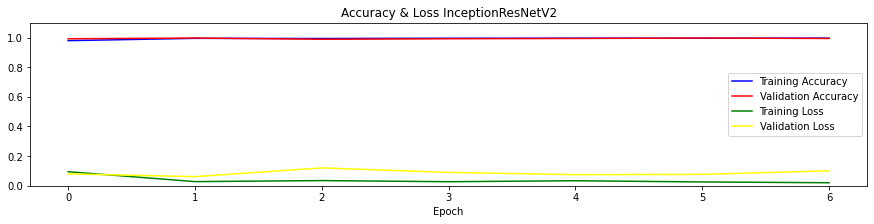

<Figure size 432x288 with 0 Axes>

In [39]:
plt.figure(figsize=(15,3))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.plot(history.history['loss'], label='Training Loss', color='green')
plt.plot(history.history['val_loss'], label='Validation Loss', color='yellow')
plt.title('Accuracy & Loss InceptionResNetV2')
plt.xlabel('Epoch')
plt.legend(loc="center right")
plt.ylim(0, 1.10)
plt.figure()

In [66]:
train_score = modelinception.evaluate(validation_generator)
train_accuracy = train_score[1] * 100
train_loss = train_score[0]

print("[INFO] train accuracy: {:.2f}%".format(train_accuracy))
print("[INFO] train Loss: ",format(train_loss))

eval('InceptionResnetV2',train_accuracy,train_loss)

24/24 [==============================] - 9s 361ms/step - loss: 0.0605 - accuracy: 0.9967
[INFO] train accuracy: 99.67%
[INFO] train Loss:  0.06049678474664688


Pada saat melakukan training model, diperoleh hasil bahwa akurasi pada data latih adalah sebesar 99.40% dan nilai loss pada data latih adalah sebesar 0.0433. Hal ini menunjukkan bahwa model deep learning yang dibangun telah berhasil mempelajari pola dari data latih dengan sangat baik.

##Testing

In [ ]:
def predict_image(imagepath, classifier):
    predict = tf.keras.utils.load_img(imagepath, target_size = (224, 224))   
    predict_modified = tf.keras.utils.img_to_array(predict)
    predict_modified = predict_modified / 255
    predict_modified = np.expand_dims(predict_modified, axis = 0)
    result = classifier.predict(predict_modified)
    plt.axis('Off')
    plt.imshow(predict)
    plt.show()
    if result[0][0] >= 0.5:
        prediction = 'Tanpa Masker'
        probability = result[0][0]
        print("probability = " + str(probability))
        print("Prediction = " + prediction)
    else:
        prediction = 'Masker'
        probability = 1 - result[0][0]
        print("probability = " + str(probability))
        print("Prediction = " + prediction)

1/1 [==============================] - 4s 4s/step


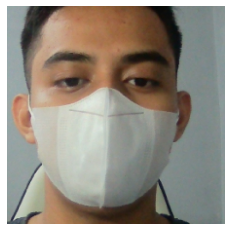

probability = 1.0
Prediction = Masker


In [ ]:
predict_image("/content/mask_a2.jpg", modelinception)

## Save Model

In [ ]:
path = "/content/"

modelinception.save(os.path.join(path, 'modelinception.h5'))
modelinception.save("./saved_model{}/".format('modelinception.h5'))

print("Keras Model {} size is: ".format('modelinception.h5'), os.path.getsize(os.path.join(path, 'modelinception.h5'))/1048576, "MB")

Keras Model modelinception.h5 size is:  209.7413101196289 MB


## Kesimpulan

Berdasarkan hasil yang diperoleh pada model face mask detection dengan menggunakan arsitektur InceptionResNetV2, didapatkan hasil akurasi sebesar 99.40% pada data latih dan data validasi. Hal ini menunjukkan bahwa model yang dibangun mampu mengenali dengan sangat baik apakah seseorang menggunakan masker atau tidak. Selain itu, dilakukan Early Stopping yang berhenti pada epoch 11, sehingga proses training tidak terlalu lama dan tetap menghasilkan performa model yang baik. Dengan hasil tersebut, dapat disimpulkan bahwa model deep learning yang dibangun dapat digunakan sebagai solusi dalam memecahkan permasalahan face mask detection

## Comparing Another Model

### MobileNetV2

In [67]:
from keras.applications import MobileNetV2

IMAGE_SIZE = [224, 224]

mnet = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in mnet.layers:
  layer.trainable = False


x = Flatten()(mnet.output)
prediction = Dense(1, activation='sigmoid')(x)

modelmnet = Model(inputs=mnet.input, outputs=prediction)

modelmnet.compile(loss = 'binary_crossentropy',
              optimizer = "adam",
              metrics = ['accuracy'])

history = modelmnet.fit(train_generator, 
                    validation_data= validation_generator,
                    steps_per_epoch=train_generator.samples//64,
                    validation_steps=validation_generator.samples//64,
                    epochs=150,
                    callbacks=[es])


Epoch 1/150
14/94 [===>..........................] - ETA: 1:07 - loss: 0.5063 - accuracy: 0.8627

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


94/94 [==============================] - 125s 918ms/step - loss: 0.1657 - accuracy: 0.9655 - val_loss: 0.1394 - val_accuracy: 0.9783
Epoch 2/150
94/94 [==============================] - 90s 961ms/step - loss: 0.0393 - accuracy: 0.9918 - val_loss: 0.1479 - val_accuracy: 0.9762
Epoch 3/150
94/94 [==============================] - 83s 886ms/step - loss: 0.0297 - accuracy: 0.9938 - val_loss: 0.1259 - val_accuracy: 0.9803
Epoch 4/150
94/94 [==============================] - 84s 895ms/step - loss: 0.0247 - accuracy: 0.9957 - val_loss: 0.2958 - val_accuracy: 0.9674
Epoch 5/150
94/94 [==============================] - 84s 894ms/step - loss: 0.0225 - accuracy: 0.9960 - val_loss: 0.1545 - val_accuracy: 0.9810
Epoch 6/150
94/94 [==============================] - 89s 941ms/step - loss: 0.0299 - accuracy: 0.9943 - val_loss: 0.2010 - val_accuracy: 0.9830
Epoch 7/150
94/94 [==============================] - 90s 961ms/step - loss: 0.0195 - accuracy: 0.9967 - val_loss: 0.1665 - val_accuracy: 0.9844
Epo

In [68]:
train_score = modelmnet.evaluate(validation_generator)
train_accuracy = train_score[1] * 100
train_loss = train_score[0]

eval('MobileNetV2',train_accuracy,train_loss)

24/24 [==============================] - 7s 276ms/step - loss: 0.1232 - accuracy: 0.9801


### VGG19

In [62]:
from keras.applications import VGG19

IMAGE_SIZE = [224, 224]

vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
  layer.trainable = False


x = Flatten()(vgg.output)
prediction = Dense(1, activation='sigmoid')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)

modelvgg.compile(loss = 'binary_crossentropy',
              optimizer = "adam",
              metrics = ['accuracy'])

history = modelvgg.fit(train_generator, 
                    validation_data= validation_generator,
                    steps_per_epoch=train_generator.samples//64,
                    validation_steps=validation_generator.samples//64,
                    epochs=150,
                    callbacks=[es])

80134624/80134624 [==============================] - 2s 0us/step
Epoch 1/150
94/94 [==============================] - 108s 1s/step - loss: 0.2765 - accuracy: 0.8899 - val_loss: 0.1245 - val_accuracy: 0.9592
Epoch 2/150
94/94 [==============================] - 100s 1s/step - loss: 0.1098 - accuracy: 0.9655 - val_loss: 0.0828 - val_accuracy: 0.9755
Epoch 3/150
94/94 [==============================] - 97s 1s/step - loss: 0.0839 - accuracy: 0.9747 - val_loss: 0.0808 - val_accuracy: 0.9694
Epoch 4/150
94/94 [==============================] - 98s 1s/step - loss: 0.0656 - accuracy: 0.9799 - val_loss: 0.0695 - val_accuracy: 0.9769
Epoch 5/150
94/94 [==============================] - 95s 1s/step - loss: 0.0527 - accuracy: 0.9870 - val_loss: 0.0890 - val_accuracy: 0.9667
Epoch 6/150
94/94 [==============================] - 95s 1s/step - loss: 0.0503 - accuracy: 0.9846 - val_loss: 0.1144 - val_accuracy: 0.9538
Epoch 7/150
94/94 [==============================] - 94s 995ms/step - loss: 0.0529 - ac

In [70]:
train_score = modelvgg.evaluate(validation_generator)
train_accuracy = train_score[1] * 100
train_loss = train_score[0]

eval('VGG19',train_accuracy,train_loss)

24/24 [==============================] - 9s 364ms/step - loss: 0.0509 - accuracy: 0.9821


### Xception

In [63]:
from keras.applications import Xception

IMAGE_SIZE = [224, 224]

xcept = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in xcept.layers:
  layer.trainable = False


x = Flatten()(xcept.output)
prediction = Dense(1, activation='sigmoid')(x)

modelxcept = Model(inputs=xcept.input, outputs=prediction)

modelxcept.compile(loss = 'binary_crossentropy',
              optimizer = "adam",
              metrics = ['accuracy'])

history = modelxcept.fit(train_generator, 
                    validation_data= validation_generator,
                    steps_per_epoch=train_generator.samples//64,
                    validation_steps=validation_generator.samples//64,
                    epochs=150,
                    callbacks=[es])

83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/150
94/94 [==============================] - 102s 1s/step - loss: 0.1061 - accuracy: 0.9794 - val_loss: 0.0931 - val_accuracy: 0.9830
Epoch 2/150
94/94 [==============================] - 100s 1s/step - loss: 0.0456 - accuracy: 0.9915 - val_loss: 0.0562 - val_accuracy: 0.9918
Epoch 3/150
94/94 [==============================] - 97s 1s/step - loss: 0.0318 - accuracy: 0.9950 - val_loss: 0.0413 - val_accuracy: 0.9946
Epoch 4/150
94/94 [==============================] - 96s 1s/step - loss: 0.0201 - accuracy: 0.9948 - val_loss: 0.0497 - val_accuracy: 0.9932
Epoch 5/150
94/94 [==============================] - 95s 1s/step - loss: 0.0227 - accuracy: 0.9957 - val_loss: 0.0849 - val_accuracy: 0.9946
Epoch 6/150
94/94 [==============================] - 96s 1s/step - loss: 0.0266 - accuracy: 0.9957 - val_loss: 0.1327 - val_accuracy: 0.9891
Epoch 7/150
94/94 [==============================] - 94s 998ms/step - loss: 0.0296 - ac

In [71]:
train_score = modelxcept.evaluate(validation_generator)
train_accuracy = train_score[1] * 100
train_loss = train_score[0]

eval('Xception',train_accuracy,train_loss)

24/24 [==============================] - 8s 322ms/step - loss: 0.0402 - accuracy: 0.9947


### Result

In [72]:
df_result = pd.DataFrame({ 'Model': MODEL,
                         'Train Accuracy': TRAIN,
                         'Loss Accuracy': LOSS})

df_result.sort_values(by='Train Accuracy',ascending=False, ignore_index=True)

,Model,Train Accuracy,Loss Accuracy
0,InceptionResnetV2,99.67,0.0605
1,Xception,99.47,0.0402
2,VGG19,98.21,0.0509
3,MobileNetV2,98.01,0.1232


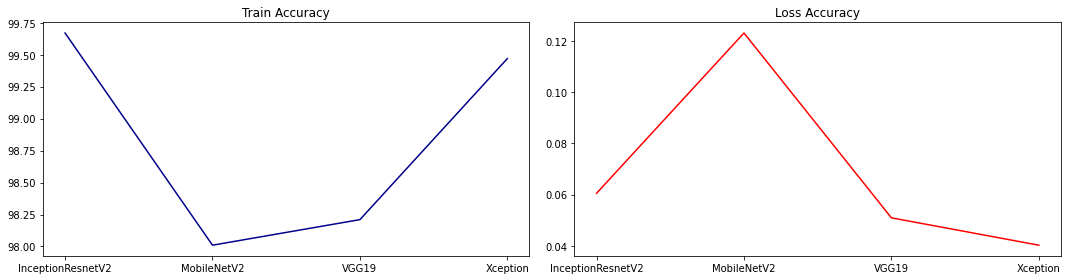

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax[0].plot(df_result["Model"], df_result["Train Accuracy"], color="darkblue")
ax[0].set_title('Train Accuracy')
ax[1].plot(df_result["Model"], df_result["Loss Accuracy"], color="red")
ax[1].set_title('Loss Accuracy')

plt.tight_layout()
plt.show()

Berdasarkan tabel yang diberikan, dapat dilihat bahwa InceptionResnetV2 dan Xception memberikan nilai train accuracy yang lebih tinggi dibandingkan dengan VGG19 dan MobileNetV2. Selain itu, Xception memiliki nilai Loss Accuracy yang paling rendah dibandingkan dengan tiga model lainnya, yang menunjukkan bahwa model tersebut lebih efektif dalam meminimalkan nilai loss pada saat training.